TODO:
1) find dataset of art to train network on <br>
2) find library for fourier transforms. Find library for neural networks <br>
3) Run fourier code on sample image. Run on large number of images to get new set of files <br>
4) Make 2 neural nets <br> 
5) Train neural net 1 on unprocessed images, train neural net 2 on processed images <br>
6) Run both nets on sample data, compare sets

(1) Import the dataset of images to classify

In [1]:
#!pip install opendatasets
#https://www.kaggle.com/code/supratimhaldar/deepartist-identify-artist-from-art/data?select=images

Create a File Set of Fourier Images

In [1]:
#use this website for fourier libraries/transform help
# https://towardsdatascience.com/image-processing-with-python-application-of-fourier-transformation-5a8584dc175b
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image, ImageOps
from skimage.io import imread, imshow
from skimage.color import rgb2hsv, rgb2gray, rgb2yuv
from skimage import color, exposure, transform
from skimage.transform import resize

from skimage.exposure import equalize_hist

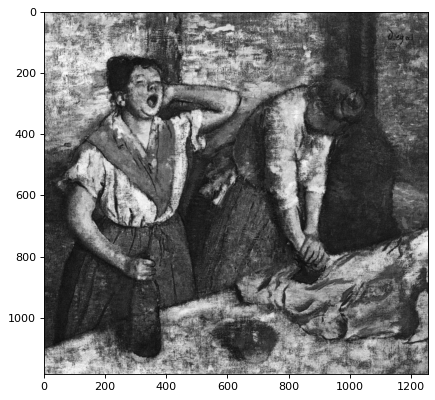

In [2]:
impath = "./images/Edgar_Degas/Edgar_Degas_1.jpg"
im = imread(impath)
im_grey = rgb2gray(im)
plt.figure(num=None, figsize=(8, 6), dpi=80)
plt.imshow(im_grey, cmap='gray')

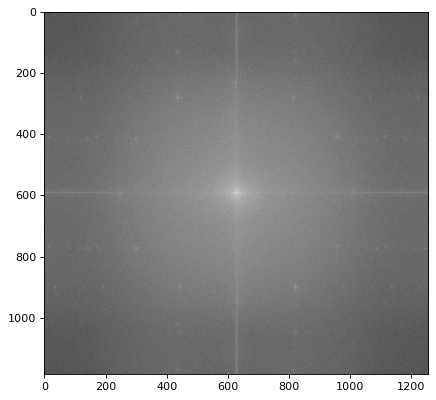

In [4]:
im_fourier = np.fft.fftshift(np.fft.fft2(im_grey))
plt.figure(num=None, figsize=(8, 6), dpi=80)
plt.imshow(np.log(abs(im_fourier)), cmap='gray')
im_fourier = Image.fromarray(abs(im_fourier).astype(np.uint8)) #took the absolute value to sustain original transform, if syntax error on range, multiply bu *255
# im_fourier.show()
im_fourier.save("./images/Edgar_Degas/Edgar_Degas_1_fourier.jpg") #saves original image to specific location

Go through the files of images and create duplicate file set of fourier transformed images

In [33]:
#dont run this cell again it takes forever
startDir = "./Documents/2021-2022/ArtCN/images"
filepath = "./images/"
for root,dirs,files in os.walk('.'):
    for filename in files:
        if filename[-4:] == ".jpg":
            fullfilename = root + "/" + filename
            #get the image and fourier transform it
            im = imread(fullfilename)
            im_grey = rgb2gray(im)
            im_fourier = np.fft.fftshift(np.fft.fft2(im_grey))
            im_fourier = Image.fromarray(abs(im_fourier).astype(np.uint8))
            im_fourier.save(fullfilename[:-4] + "_fourier" + fullfilename[-4:])
#             os.remove(fullfilename) 
            

<ipython-input-33-7d06404c9748>:10: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  im_grey = rgb2gray(im)


(480, 640)

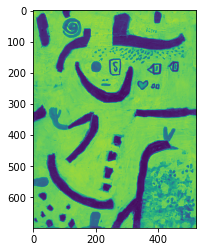

In [55]:
im = imread("./images/Paul_Klee/Paul_Klee_110.jpg", as_gray=True)
plt.imshow(im)
im_fourier = np.fft.fftshift(np.fft.fft2(im))
im_fourier = Image.fromarray(abs(im_fourier).astype(np.uint8))
im_fourier = im_fourier.resize((480,640))
im_fourier.show()
im_fourier.size

Neural Network Portion: Convolutional Neural Net
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html for the starting point, also used https://www.analyticsvidhya.com/blog/2019/10/building-image-classification-models-cnn-pytorch/
- Make 2 nets - one to compare images directly, and the other to compare the fourier ones
- Set aside data as training data
- train the nets
- test the nets

In [132]:
!pip3 install tqdm

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 KB 2.3 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [2]:
# convert np arrays to torch.*Tensor before doing the net stuff
import torch
import torchvision
import torchvision.transforms as transforms

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score

#for evaluating the model
from tqdm import tqdm

# PyTorch libraries and modules
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

/Users/ariannameinking/Library/Python/3.8/lib/python/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#first create the labels / images datasets
startDir = "./Documents/2021-2022/ArtCN/images"
filepath = "./images"
train_x = []
train_x_fourier = []
train_y = []
train_y_fourier = []

In [4]:
imcount = 0
imcountF = 0
train_im = []
train_im_fourier = []
train_names = [] # define the labels here because they will simply be the foldername for each image
train_names_fourier = []
#https://www.pluralsight.com/guides/importing-image-data-into-numpy-arrays 
for root,dirs,files in os.walk('./images'):
    for filename in files:
        if filename[-4:] == ".jpg":
            #add the image to the image set
            im_path = root + "/" + filename
            im = imread(im_path, as_gray = True)
            im = im/255.0
            im = resize(im,(480,640))
            trainName = filename.split("_")
            if "fourier" in im_path:
                imcountF += 1
                train_im_fourier.append(im)
                train_names_fourier += [filename]
            else:
                imcount += 1
                train_im.append(im)
                train_names += [filename]

In [6]:

print(imcount)
print(imcountF)

746
746


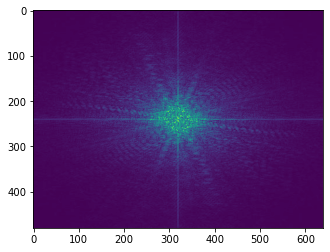

In [6]:
plt.imshow(train_im_fourier[52])

In [5]:
artistD = {"Albrecht_Dürer": int(0), "Andy_Warhol": int(1), "Frida_Kahlo": int(2), "Gustav_Klimt": int(3)}
for i in range(len(train_names)):
    nameL = train_names[i].split("_")
    nameFL = train_names_fourier[i].split("_")
    train_names[i] = nameL[0] + "_" + nameL[1]
    train_names_fourier[i] = nameFL[0] + "_" + nameFL[1]
print(train_names)

['Andy_Warhol', 'Andy_Warhol', 'Andy_Warhol', 'Andy_Warhol', 'Andy_Warhol', 'Andy_Warhol', 'Andy_Warhol', 'Andy_Warhol', 'Andy_Warhol', 'Andy_Warhol', 'Andy_Warhol', 'Andy_Warhol', 'Andy_Warhol', 'Andy_Warhol', 'Andy_Warhol', 'Andy_Warhol', 'Andy_Warhol', 'Andy_Warhol', 'Andy_Warhol', 'Andy_Warhol', 'Andy_Warhol', 'Andy_Warhol', 'Andy_Warhol', 'Andy_Warhol', 'Andy_Warhol', 'Andy_Warhol', 'Andy_Warhol', 'Andy_Warhol', 'Andy_Warhol', 'Andy_Warhol', 'Andy_Warhol', 'Andy_Warhol', 'Andy_Warhol', 'Andy_Warhol', 'Andy_Warhol', 'Andy_Warhol', 'Andy_Warhol', 'Andy_Warhol', 'Andy_Warhol', 'Andy_Warhol', 'Andy_Warhol', 'Andy_Warhol', 'Andy_Warhol', 'Andy_Warhol', 'Andy_Warhol', 'Andy_Warhol', 'Andy_Warhol', 'Andy_Warhol', 'Andy_Warhol', 'Andy_Warhol', 'Andy_Warhol', 'Andy_Warhol', 'Andy_Warhol', 'Andy_Warhol', 'Andy_Warhol', 'Andy_Warhol', 'Andy_Warhol', 'Andy_Warhol', 'Andy_Warhol', 'Andy_Warhol', 'Andy_Warhol', 'Andy_Warhol', 'Andy_Warhol', 'Andy_Warhol', 'Andy_Warhol', 'Andy_Warhol', 'Andy_War

In [6]:
train_y = []
train_y_fourier = []
for i in range(len(train_names)):
    #print(train_y)
    train_y += [artistD[train_names[i]]]
    #print(train_y_fourier)
    train_y_fourier += [artistD[train_names_fourier[i]]]


In [7]:
train_y = np.array(train_y, dtype=int)
train_y_fourier = np.array(train_y_fourier, dtype=int)
print(train_y)
print(train_y_fourier)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [8]:
train_x = np.array(train_im)
train_x_fourier = np.array(train_im_fourier)

(746, 480, 640)
(746,)
(746, 480, 640)


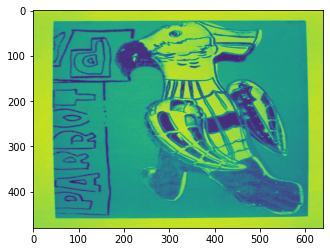

In [9]:
print(train_x.shape)
print(train_y.shape)
print(train_x_fourier.shape)
plt.imshow(train_x[12])

In [10]:
# create validation set
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size = 0.1)
(train_x.shape, train_y.shape), (val_x.shape, val_y.shape)


# create validation set for the fourier nn
train_x_fourier, val_x_fourier, train_y_fourier, val_y_fourier = train_test_split(train_x_fourier, train_y_fourier, test_size = 0.1)
(train_x_fourier.shape, train_y_fourier.shape), (val_x_fourier.shape, val_y_fourier.shape)

(((671, 480, 640), (671,)), ((75, 480, 640), (75,)))

In [11]:
# Non-Fourier Images
# converting training images into torch format
train_x = train_x.reshape(671, 1, 480, 640)
train_x  = torch.from_numpy(train_x)
# train_x  = torch.from_numpy(np.asarray(train_x))

# converting the target into torch format
print(train_y)
#train_y = train_y.astype(int);  # does the training set need to have integers to work
train_y = torch.tensor(train_y, dtype=int)
print(train_y)

# shape of training data
train_x.shape, train_y.shape


# Fourier Images
# converting training images into torch format
train_x_fourier = train_x_fourier.reshape(671, 1, 480, 640) 
train_x_fourier  = torch.from_numpy(train_x_fourier)

# converting the target into torch format
#train_y_fourier = train_y.astype(int);  # does the training set need to have integers to work
train_y_fourier = torch.from_numpy(train_y_fourier)

# shape of training data
train_x.shape, train_y.shape

[0 3 3 1 3 3 0 1 2 0 1 0 0 1 1 1 2 1 0 3 0 0 0 0 0 1 3 1 1 0 0 3 0 3 2 2 1
 0 1 2 2 0 0 3 0 0 2 1 0 3 0 1 0 1 3 1 1 0 0 0 1 0 0 0 2 2 0 2 0 2 2 3 1 0
 3 0 0 1 1 1 2 0 0 1 0 1 3 0 2 0 0 1 1 3 0 1 2 1 1 3 0 0 3 0 3 0 2 1 0 0 2
 0 0 3 0 0 3 0 0 1 2 1 3 2 1 1 2 1 0 0 0 3 1 0 0 0 3 3 2 2 1 0 1 2 0 2 0 3
 0 2 0 2 1 1 0 3 0 0 2 1 0 0 0 1 0 1 1 1 1 2 0 0 1 2 0 0 1 1 0 0 0 1 0 2 3
 1 2 3 0 0 2 0 2 2 1 0 0 1 0 3 1 3 1 2 3 0 1 0 0 3 0 1 3 3 0 0 3 2 2 0 0 0
 0 3 0 0 1 0 1 1 0 2 3 3 0 0 0 1 0 0 0 1 1 2 0 1 3 2 0 3 3 0 1 2 2 2 0 1 0
 0 0 0 0 0 1 0 0 3 1 0 0 3 1 0 0 0 0 1 0 1 1 0 1 0 1 3 0 3 2 2 1 3 2 2 1 2
 0 0 0 0 3 0 0 1 0 0 0 1 1 0 2 3 2 0 0 3 3 0 1 0 0 0 2 0 0 0 3 2 1 3 1 0 1
 3 2 0 0 0 0 0 0 0 3 1 3 0 3 1 2 2 2 0 1 3 3 1 3 0 2 0 2 2 3 0 1 3 0 0 3 0
 0 1 0 1 3 1 0 2 0 2 2 0 0 0 0 0 2 1 2 0 0 0 0 1 0 3 1 2 0 0 2 3 0 0 1 0 0
 3 0 0 2 2 0 2 3 2 2 0 0 0 0 1 0 0 1 0 2 3 3 3 0 0 1 1 2 0 3 1 1 3 0 1 0 0
 2 1 0 2 0 2 0 1 2 3 1 1 1 0 2 0 1 0 1 1 3 3 0 1 1 0 2 2 3 3 0 1 3 0 2 0 1
 1 1 3 2 1 1 2 3 0 0 0 0 

(torch.Size([671, 1, 480, 640]), torch.Size([671]))

In [12]:
# converting validation images into torch format
val_x = val_x.reshape(75, 480, 640)
val_x  = torch.from_numpy(val_x)

# converting the target into torch format
#val_y = val_y.astype(int);
val_y = torch.from_numpy(val_y)

# shape of validation data
val_x.shape, val_y.shape

(torch.Size([75, 480, 640]), torch.Size([75]))

In [28]:
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(1, 4, kernel_size=5, stride=1, padding=2),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=5, stride=2),
            # Defining another 2D convolution layer
            Conv2d(4, 4, kernel_size=5, stride=1, padding=2),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=5, stride=2),
        )

        self.linear_layers = Sequential(
            Linear(73476, 4)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [29]:

# defining the model
model = Net()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.07)
# defining the loss function
criterion = CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=5, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=5, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=73476, out_features=4, bias=True)
  )
)


In [31]:
def train(epoch):
    model.train()
    tr_loss = 0
    # getting the training set
    x_train, y_train = Variable(train_x), Variable(train_y)
    # getting the validation set
    x_val, y_val = Variable(val_x), Variable(val_y)
    # converting the data into GPU format
    if torch.cuda.is_available():
        x_train = x_train.cuda()
        y_train = y_train.cuda()
        x_val = x_val.cuda()
        y_val = y_val.cuda()

    # clearing the Gradients of the model parameters
    optimizer.zero_grad()
    
    # prediction for training and validation set
    output_train = model(x_train)
    output_val = model(x_val)

    # computing the training and validation loss
    loss_train = criterion(output_train, y_train)
    loss_val = criterion(output_val, y_val)
    train_losses.append(loss_train)
    val_losses.append(loss_val)

    # computing the updated weights of all the model parameters
    loss_train.backward()
    optimizer.step()
    tr_loss = loss_train.item()
    if epoch%2 == 0:
        # printing the validation loss
        print('Epoch : ',epoch+1, '\t', 'loss :', loss_val)


In [32]:

# defining the number of epochs
n_epochs = 1
# empty list to store training losses
train_losses = []
# empty list to store validation losses
val_losses = []
# training the model
model = model.double()
for epoch in range(n_epochs):
    train(epoch)
#https://stackoverflow.com/questions/69778174/runtime-error-mat1-and-mat2-shapes-cannot-be-multiplied-in-pytorch 
#https://www.tutorialspoint.com/pytorch/pytorch_convolutional_neural_network.htm
# https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/02-intermediate/convolutional_neural_network/main.py#L35-L56 

Error: Canceled future for execute_request message before replies were done